In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

# First load the data

In [2]:
# scipy.io, here loaded as 'sio' is a function to load data from a matlab file
data = sio.loadmat('sim.mat')

In [3]:
d = data['Data']

## Split the data into test, train, and validation sets

In [4]:
train = np.concatenate((d[0:500], d[1500:2000], d[3000:3500], d[4500:]))

In [5]:
test = np.concatenate((d[500:1000], d[2000:2500], d[3500:4000]))

In [6]:
val = np.concatenate((d[1000:1500], d[2500:3000], d[4000:4500]))

In [7]:
x_train = np.delete(train, 34, axis=1)
y_train = train[:, 34]

In [8]:
x_test = np.delete(test, 34, axis=1)
y_test = test[:, 34]

In [9]:
x_val = np.delete(val, 34, axis=1)
y_val  = val[:, 34]

## Use `scikit-learn`'s normalization

In [10]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

In [11]:
X_train = x_scaler.fit_transform(x_train)
Y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))

# Traditional (single regularization) Ridge Regression

In [12]:
simple_ridge = linear_model.Ridge(alpha=10.0)

In [13]:
simple_ridge.fit(X_train, Y_train)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

## Check the error

In [14]:
X_test = x_scaler.transform(x_test)

In [15]:
mean_squared_error(y_val, y_scaler.inverse_transform(simple_ridge.predict(X_test)))

0.66194072929083281

## Concept proven; now calculate MSE for a variety of $\alpha^2$ values

To determine the range of values to check for alpha we find the singular values

In [16]:
U, s, Vh = np.linalg.svd(X_train)
alpha_min = min(s)
alpha_max = max(s)

print([alpha_min, alpha_max])

[2.8860179913035178, 164.24424930494501]


In [17]:
# ~Equivalent to Matlab 0:0.1:20
alphas = np.linspace(alpha_min, alpha_max, 1000)

In [18]:
mse = []
b_mag = []
for a in alphas:
    mdl = linear_model.Ridge(alpha=a)
    mdl.fit(X_train, Y_train)
    m = mean_squared_error(y_test, y_scaler.inverse_transform(mdl.predict(X_test)))
    mse.append(m)
    b = np.linalg.norm(mdl.coef_)
    b_mag.append(b)

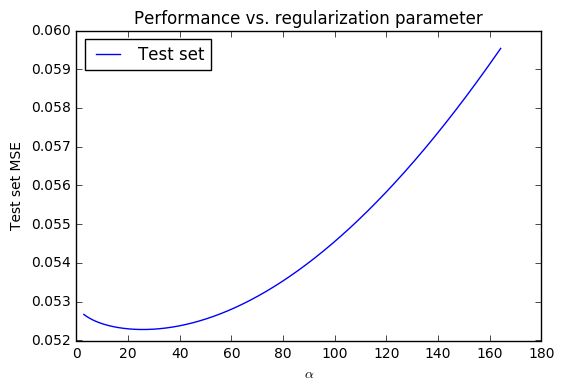

In [19]:
plt.plot(alphas, np.array(mse), label='Test set')
plt.title(r'Performance vs. regularization parameter')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Test set MSE')
plt.legend(loc='upper left')
plt.savefig('images/simple_alpha_full.png', dpi=300)
plt.show()

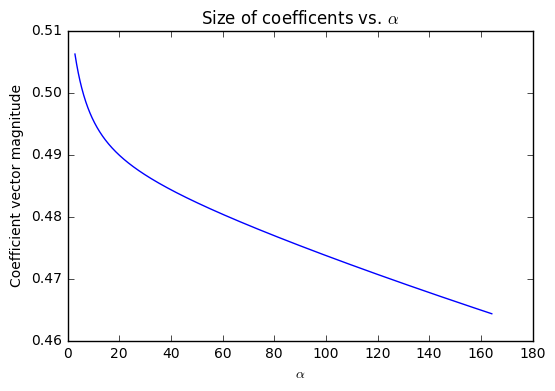

In [20]:
plt.plot(alphas, np.array(b_mag))
plt.title(r'Size of coefficents vs. $\alpha$')
plt.xlabel(r'$\alpha$')
plt.ylabel('Coefficient vector magnitude')
plt.savefig('images/simple_coeff_mag.png', dpi=300)
plt.show()

Here the best value for $\alpha$ appears to be between 20 and 30

In [21]:
alphas2 = np.linspace(20, 30, 1000)
mse2 = []
for a in alphas2:
    mdl = linear_model.Ridge(alpha=a)
    mdl.fit(X_train, Y_train)
    m = mean_squared_error(y_test, y_scaler.inverse_transform(mdl.predict(x_scaler.transform(x_test))))
    mse2.append(m)

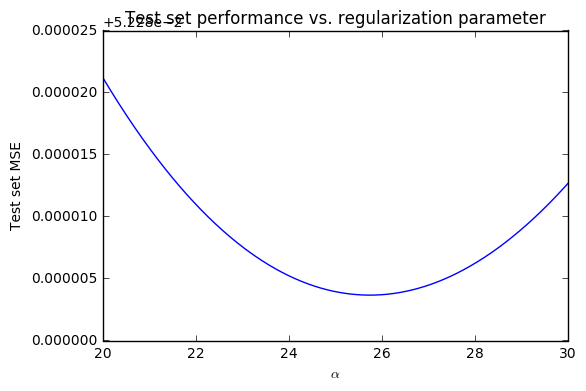

In [22]:
plt.plot(alphas2, np.array(mse2), label='Test set')
plt.title(r'Test set performance vs. regularization parameter')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Test set MSE')
plt.savefig('images/simple_alpha.png', dpi=300)
plt.show()

In [23]:
alphas3 = np.linspace(20, 30, 1000)
mse3 = []
for a in alphas3:
    mdl = linear_model.Ridge(alpha=a)
    mdl.fit(X_train, Y_train)
    m = mean_squared_error(y_val, y_scaler.inverse_transform(mdl.predict(x_scaler.transform(x_val))))
    mse3.append(m)

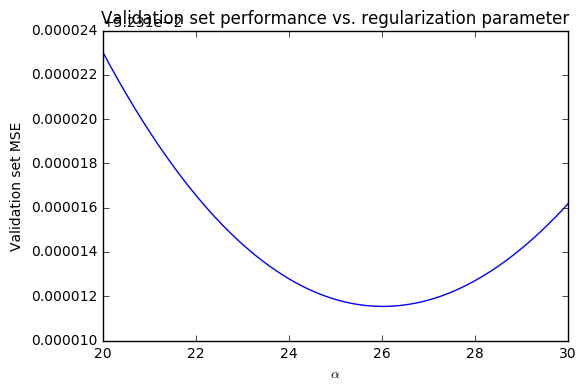

In [24]:
plt.plot(alphas2, np.array(mse3), label='Test set')
plt.title(r'Validation set performance vs. regularization parameter')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Validation set MSE')
plt.savefig('images/simple_alpha_val.png', dpi=300)
plt.show()

## We can also use the `RidgeCV` estimator to optimize $\alpha$

This implements "Leave One Out Cross Validation"

In [25]:
simple_ridge2 = linear_model.RidgeCV(alphas=np.linspace(20, 30, 1000))

In [26]:
simple_ridge2.fit(X_train, Y_train)

RidgeCV(alphas=array([ 20.     ,  20.01001, ...,  29.98999,  30.     ]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [27]:
simple_ridge2.alpha_

20.860860860860861

Here we see that the data in the training set is slightly different from that in the test set. Leave one out cross validation optimizes alpha based on values in the training set, explaining the difference in the values from each method.

# Now we implement the local ridge regression method

In [28]:
np.linalg.cond(x_train)

102.94187511494458

In [29]:
np.linalg.cond(X_train)

56.910334516231281

## Set up our objective function

In [35]:
def b(x, y, alpha):
    x = np.matrix(x)
    # U, v, Vh = np.linalg.svd(x)
    # Vht = np.matrix.transpose(Vh)
    xt = np.matrix.transpose(x)
    #tmp = np.dot(xt, x) + np.dot(np.dot(Vht, alpha ** 2), Vh)
    tmp = (xt * x) + np.diag(alpha **2)
    tmp = np.linalg.inv(tmp)
    tmp = tmp * xt
    return np.dot(tmp, y)

In [36]:
obj = lambda alpha: mean_squared_error(y_test, y_scaler.inverse_transform(np.dot(X_test, b(X_train, Y_train, alpha))))

In [42]:
m = minimize(obj, 20*np.ones(43))
m

     njev: 100
        x: array([ 23.23160907,  17.897713  ,  23.89812134,  22.76287245,
        17.36462333,  18.22188206,  13.28934158,  23.7402606 ,
        22.38936214,  20.34866095,  30.95464722,  17.41164365,
        19.17034614,   9.94452453,  21.31234708,  19.870761  ,
        18.73570753,  18.75712876,  19.84798988,  92.69333931,
        20.04928966,  14.93198627,  18.05289235,  17.32447379,
        21.8875054 ,  17.97907707,  60.75513588,  16.63701842,
        20.15318714,  37.11147519,  27.87843877,  29.12944175,
        19.80039616,   4.92543678,   5.75832066,  -0.56210281,
        -6.36332323,   4.74830654,   6.672874  ,  21.24187756,
        42.80555694,  20.46541857,  34.99293024])
  success: True
   status: 0
  message: 'Optimization terminated successfully.'
 hess_inv: array([[  6.33185057e+03,  -4.83765182e+03,   8.93688237e+03, ...,
          5.23809896e+04,   1.06972805e+03,   3.44535247e+04],
       [ -4.83765182e+03,   3.70544096e+03,  -6.84285050e+03, ...,
      

In [44]:
alphas = m['x']

In [46]:
U, s, Vh = np.linalg.svd(X_train)

In [47]:
s

array([ 164.2442493 ,  137.29800066,  126.85019067,   58.97905152,
         45.95617991,   45.03351988,   44.68661469,   43.78270031,
         43.23815105,   27.02323948,   26.90414794,   26.83840529,
         26.59507472,   26.16347542,   25.62656102,   25.34468711,
         25.03222822,   24.68300608,   22.94586409,   22.60581013,
         22.18175037,   21.96610867,   21.59074253,   21.22600153,
         17.22270585,   17.01459175,   16.66993103,   16.34007346,
         16.18104629,    8.17767972,    5.85606593,    5.74134765,
          5.67198106,    3.1969942 ,    3.12770864,    3.07583982,
          3.06341271,    3.04127153,    2.99011847,    2.96735505,
          2.92779813,    2.90443467,    2.88601799])

In [48]:
ff = s / (s + alphas)
ff

array([ 0.87608213,  0.8846765 ,  0.84147006,  0.72152757,  0.72576748,
        0.71193161,  0.7707784 ,  0.64841203,  0.65884183,  0.57044871,
        0.46499668,  0.60651696,  0.58111723,  0.72458944,  0.54595563,
        0.56053159,  0.57193075,  0.5682074 ,  0.53619532,  0.19606225,
        0.52524755,  0.59531823,  0.54462066,  0.55060285,  0.44036341,
        0.48621915,  0.21530406,  0.49549771,  0.44533887,  0.18056596,
        0.17359276,  0.16464633,  0.22267184,  0.39360066,  0.35198046,
        1.22361242, -0.92833206,  0.39042828,  0.30944022,  0.12257121,
        0.06401888,  0.12428125,  0.07619055])

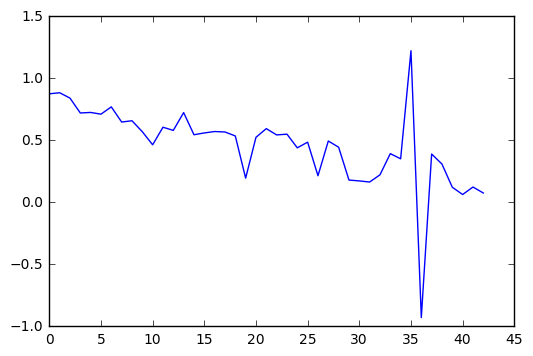

In [49]:
plt.plot(ff)
plt.show()

In [50]:
obj(alphas)

0.051142195132296779